<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo04_treino_avaliacao_BERTimbau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Treino e Avaliação do Modelo BERTimbau

### Iniciando pela configuração do Google Colab

In [2]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
     |████████████████████████████████| 101 kB 11.4 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importação de bibliotecas utilizadas no treino e avaliação
import datetime
import os
import random
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display
from sklearn.metrics import (accuracy_score, auc, classification_report, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve,
                             mean_squared_error, root_mean_squared_error)
from torch.utils.data import (DataLoader, TensorDataset)
from transformers import (AutoModelForSequenceClassification, AutoTokenizer)
from transformers.file_utils import is_torch_available

In [ ]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
# configura tema dos gráficos
sns.set_theme(style="white")
#configura a barra de progressos para usar no apply
tqdm.pandas()

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Carrega dados pré-processados

In [ ]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6703 entries, 0 to 6702
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   texto             6703 non-null   object
 1   classe            6703 non-null   int64 
 2   texto_limpo       6703 non-null   object
 3   qtde_limpo        6703 non-null   int64 
 4   texto_lematizado  6703 non-null   object
 5   qtde_lematizado   6703 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 314.3+ KB


### Geração de seed  
Rotina para garantir a reprodução dos resultados mesmo que o ambiente for reiniciado.  
Semente aplicada às libs random, numpy e torch.

In [ ]:
RANDOM_SEED = 42
def garantir_reprodutividade(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            return "cuda"
    return "cpu"

device = garantir_reprodutividade(RANDOM_SEED)

### Carregando o modelo pré-treinado BERTimbau

In [ ]:
MODELO_LOCAL = "/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau"
MODELO_ORIGEM = "neuralmind/bert-base-portuguese-cased"

# carrega tokenizador
tokenizer = AutoTokenizer.from_pretrained(
    MODELO_ORIGEM, 
    # não altera case, pois o modelo é case-sensitive
    do_lower_case=False
)
# carrega pesos do modelo "BERTimbau"
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODELO_ORIGEM, 
    num_labels=2          # número de classes da classificação
).to(device)   # coloca o modelo para rodar na GPU
# configura otimizador com learning rate baixo
optimizer = torch.optim.AdamW(model_bert.parameters(), lr = 1e-5)

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

### Tokeniza todos textos para acelerar o treino

In [ ]:
campo_texto = 'texto_lematizado' #'texto_wordcloud_nomes_numeros'
dados_token = dados[['classe', campo_texto]].copy()
dados_token['TOKENS'] = dados_token[campo_texto].progress_apply(
    lambda x: np.array(
        tokenizer.encode(x, padding='max_length', 
                         truncation=True, max_length=300)))
dados_token.rename(columns={'classe':'LABELS'}, inplace=True)

  0%|          | 0/6703 [00:00<?, ?it/s]

### Separa treino, validação e teste e gera datasets de tensoes

In [ ]:
# Separa 60% para treino, 20% para validação e 20% para teste
dados_treino, dados_validacao, dados_teste = np.split(
    dados_token.sample(frac=1), [
      int(.6*len(dados_token)), 
      int(.8*len(dados_token))
])
lote_tamanho = 4
lote_status = 32

# gera dataset e leitor de dados de treino
treino_dados = TensorDataset(
    torch.tensor(np.array(dados_treino['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_treino['LABELS'].values)).to(device))
treino_leitor = DataLoader(treino_dados, batch_size=lote_tamanho, shuffle=True)

# gera dataset e leitor de dados de validação
validacao_dados = TensorDataset(
    torch.tensor(np.array(dados_validacao['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_validacao['LABELS'].values)).to(device))
validacao_leitor = DataLoader(validacao_dados, batch_size=lote_tamanho, shuffle=True)

# gera dataset e leitor de dados de validação
teste_dados = TensorDataset(
    torch.tensor(np.array(dados_teste['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_teste['LABELS'].values)).to(device))
teste_leitor = DataLoader(teste_dados, batch_size=lote_tamanho, shuffle=True)


### Método de Avaliação do Modelo

In [ ]:
def avaliar_modelo(modelo, dados):
  modelo.eval() # coloca o modelo em avaliação
  classes_real, classes_pred = [], []
  for idx_lote, lote in enumerate(dados):
    # pega os dados do lote
    lote_valores = lote[0].to(device)
    lote_classes = lote[1].to(device)

    # realiza predição
    outputs = model_bert(lote_valores)    
    # retorna indice de maior valor na predição
    pred_classes = torch.argmax(outputs.logits, 1)
    # salva retorno para medição
    classes_real.extend(lote[1].tolist())
    classes_pred.extend(pred_classes.tolist())

  # Obtem f1, acurácia e loss da validação
  f1 = f1_score(classes_real, classes_pred, average='weighted')
  acuracia = accuracy_score(classes_real, classes_pred)
  loss = mean_squared_error(classes_real, classes_pred)
  return f1, acuracia, loss

### Treinamento Completo

In [ ]:
epocas = 5
parar_treino = 2    
max_f1, repetir_treino = 0, 0
estatisticas = []
inicio = time.time()

for epoca in range(0, epocas):
  f1, acc, _ = avaliar_modelo(model_bert, validacao_leitor)
  model_bert.train()
  losses = []
  for idx_lote, lote in enumerate(treino_leitor):
    # pega os dados do lote
    lote_valores = lote[0].to(device)
    lote_classes = lote[1].to(device)

    # treina no lote atual
    output = model_bert(lote_valores, labels=lote_classes)
    # Salva o loss
    loss = output.loss
    losses.append(float(loss))
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # imprime processo
    if (idx_lote+1) % (lote_status) == 0:
      print("Época: {} [{}/{} ({:.0f}%)]".format(epoca + 1, idx_lote+1, \
        len(treino_leitor), 100. * idx_lote / len(treino_leitor)) \
        + "\tLoss: {:.6f}\tLoss Total: {:.6f}".format(
            float(loss) , round(sum(losses) / len(losses), 5)))
  
  print('Validando...')
  f1, acc, losses_val = avaliar_modelo(model_bert, validacao_leitor)
  print('F1: ', f1, 'Acurácia: ', acc, 'Loss: ', losses_val)

  # grava as estatísticas por época.
  estatisticas.append(
      {
          'epoca': epoca + 1,
          'Loss de Treinamento': round(sum(losses) / len(losses), 5),
          'Loss de Validação': round(losses_val, 5),
          'F1': round(f1, 5),
          'Acurácia de Validação': round(acc, 5)
      }
  )

  if f1 > max_f1:
    model_bert.save_pretrained(MODELO_LOCAL)
    max_f1 = f1
    repeat = 0
    print('Salvando melhor modelo...')
  else:
    repetir_treino += 1
  if repetir_treino == parar_treino:
    break

print("Tempo total do treino {:} (h:mm:ss)".format(format_time(time.time()-inicio)))

Progresso: 0.37 31
Progresso: 0.75 63
              precision    recall  f1-score   support

   Confiável       0.55      0.02      0.04       318
       Falso       0.53      0.99      0.69       352

    accuracy                           0.53       670
   macro avg       0.54      0.50      0.36       670
weighted avg       0.54      0.53      0.38       670

Época: 1 [32/587 (5%)]	Loss: 0.608414	Loss Total: 0.605600
Época: 1 [64/587 (11%)]	Loss: 0.276066	Loss Total: 0.492780
Época: 1 [96/587 (16%)]	Loss: 0.376243	Loss Total: 0.456270
Época: 1 [128/587 (22%)]	Loss: 0.365763	Loss Total: 0.408370
Época: 1 [160/587 (27%)]	Loss: 0.044171	Loss Total: 0.376700
Época: 1 [192/587 (33%)]	Loss: 0.427981	Loss Total: 0.344780
Época: 1 [224/587 (38%)]	Loss: 0.049338	Loss Total: 0.328520
Época: 1 [256/587 (43%)]	Loss: 0.084038	Loss Total: 0.317670
Época: 1 [288/587 (49%)]	Loss: 0.270750	Loss Total: 0.307670
Época: 1 [320/587 (54%)]	Loss: 0.026597	Loss Total: 0.288930
Época: 1 [352/587 (60%)]	Loss

### Teste do Modelo tunado

In [ ]:
classes_previstas , classes_verdadeiras = [], []

for lote in teste_leitor:
    # coloca o lote na GPUS
    lote = tuple(t.to(device) for t in lote)
    lote_valores, lote_classes = lote
    with torch.no_grad():
        outputs = model_bert(lote_valores)

    # Adiciona as prediões e as classes para a CPU
    outputs = outputs.logits.detach().cpu().numpy()
    classes = lote_classes.to('cpu').numpy()

    # Salva as predições e as classes corretos
    classes_previstas.append(outputs)
    classes_verdadeiras.append(classes) 

# prepara resultado
lista_previsoes = np.concatenate(classes_previstas, axis=0)
lista_previsoes = np.argmax(lista_previsoes, axis=1).flatten()
lista_classes_verdadeiras = np.concatenate(classes_verdadeiras, axis=0)

### Relatório de classificação

In [ ]:
print(classification_report(lista_classes_verdadeiras, lista_previsoes,target_names=['confiável','falso']))

              precision    recall  f1-score   support

   confiável       0.97      0.98      0.97       650
       falso       0.98      0.97      0.97       691

    accuracy                           0.97      1341
   macro avg       0.97      0.97      0.97      1341
weighted avg       0.97      0.97      0.97      1341



### Gráfico da Acurácia

In [ ]:
print(accuracy_score(lista_classes_verdadeiras, lista_previsoes))

0.9731543624161074


### Matriz de confusão

[[634  16]
 [ 20 671]]


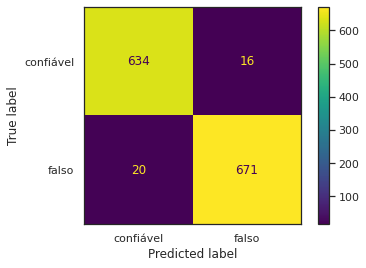

In [ ]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

### Curva ROC
Receiver Operating Characteristic Curve

In [3]:
fpr, tpr, _ = roc_curve(lista_classes_verdadeiras, lista_previsoes)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Positive Real')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: ignored

### Gera as estatísticas do treino

In [ ]:
# Cria um dataframe das estatísticas
pd.set_option('precision', 3)
df_estatisticas = pd.DataFrame(data=estatisticas)
df_estatisticas = df_estatisticas.set_index('epoca')

### Curva de aprendizado

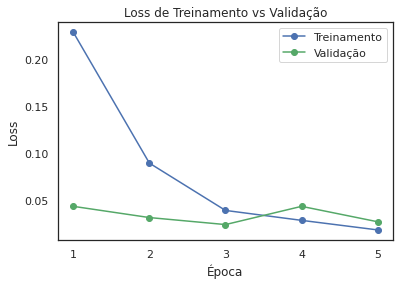

In [ ]:
plt.figure()
# Mostra curva de aprendizado.
plt.plot(df_estatisticas['Loss de Treinamento'], 'b-o', label="Treinamento")
plt.plot(df_estatisticas['Loss de Validação'], 'g-o', label="Validação")
plt.title("Loss de Treinamento vs Validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()

### Acurácia

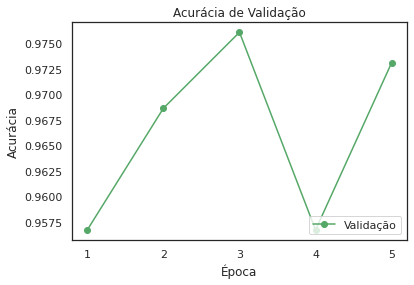

In [ ]:
plt.figure()
plt.plot(df_estatisticas['Acurácia de Validação'], 'g-o', label="Validação")
plt.title("Acurácia de Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend(loc="lower right")
plt.xticks([1, 2, 3, 4, 5])
plt.show()